In [27]:
# Here we import everything we need for the project

%matplotlib inline
# from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import timeit
import copy
import seaborn as sns


# Sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix, classification_report # Helps present results as a confusion-matrix
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc


# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

print(tf.__version__)

2.6.0


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=313bbd2ebcd25c82a96219ddce1229bf403266911b13e8306c9656c3c4cbaa7f
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
from google.colab import drive, files
drive.mount('/content/gdrive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

Mounted at /content/gdrive


In [7]:
! pwd
#! mkdir "gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle
! pwd

/content
/content/gdrive/My Drive/Kaggle
/content/gdrive/My Drive/Kaggle


In [ ]:
! kaggle datasets download -d gti-upm/leapgestrecog

leapgestrecog.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! pwd
! ls

/content/gdrive/My Drive/Kaggle
'2021-08-29-195052 (1).avi'   kaggle.json     leapGestRecog
 2021-08-29-195052.avi	      leapgestrecog   leapgestrecog.zip


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

In [8]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle/leapGestRecog

/content/gdrive/My Drive/Kaggle/leapGestRecog


In [9]:
def paths_to_images(root_path):
    # We need to get all the paths for the images to later load them
    imagepaths = []

    # Go through all the files and subdirectories inside a folder and save path to images inside list
    for root, dirs, files in os.walk(root_path, topdown=False): 
      for name in files:
        path = os.path.join(root, name)
        if path.endswith("png"): # We want only the images
          imagepaths.append(path)

    print(len(imagepaths)) # If > 0, then a PNG image was loaded
    return imagepaths

In [10]:
def plot_image(path_or_im):
    if type(path_or_im) == str:  
        img = cv2.imread(path_or_im) # Reads the image into a numpy.array
        img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
    else:
        img_cvt = path_or_im
    print(img_cvt.shape) # Prints the shape of the image just to check
    plt.grid(False) # Without grid so we can see better
    plt.imshow(img_cvt) # Shows the image
    plt.xlabel("Width")
    plt.ylabel("Height")
    
    if type(path_or_im) == str:
        plt.title("Image " + path_or_im)
        
    plt.show(block=False)

In [11]:
def load_images(imagepaths):
    X = [] # Image data
    y = [] # Labels

    # Loops through imagepaths to load images and labels into arrays
    for i, path in enumerate(imagepaths):
        img = cv2.imread(path) # Reads image and returns np.array
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the correct colorspace (GRAY)
        img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
        X.append(img)


        # Processing label in image path
        category = path.split("/")[2] 
        label = int(category.split("_")[0][1]) 
        y.append(label)

        if (i % 100) == 0:
            print("loaded %d images" % i) 

    print("Images loaded: ", len(X))
    print("Labels loaded: ", len(y))

    # print(y[0], imagepaths[0]) # Debugging
    return X, y

In [12]:
# image augmentation functions
def rotate(img, angle):
    # angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    return cv2.warpAffine(img, M, (w, h))

def flip_hor(img):
    return cv2.flip(img, 0)

def flip_ver(img):
    return cv2.flip(img, 1)

def flip_both(img):
    return cv2.flip(img, -1)

In [13]:
def augment_dataset(X, y):
    X_new = []
    y_new = []
    for i in range(len(X)):
        img = copy.deepcopy(X[i])
        
        # rotate
        angle = int(random.uniform(-180, 180))
        img_rot = rotate(img, angle)
        
        # flip
        img_flip = flip_hor(img)
        
        X_new.append(img)
        X_new.append(img_rot)
        X_new.append(img_flip)
        
        y_new.append(y[i])
        y_new.append(y[i])
        y_new.append(y[i])
    return X_new, y_new
    
def cv2_to_numpy(X, y):
    # Turn X and y into np.array to speed up train_test_split
    X = np.array(X, dtype="uint8")
    X = np.expand_dims(X, -1) # Needed to reshape so CNN knows it's different images
    y = np.array(y)
    return X, y

In [16]:
t = timeit.default_timer()
root_path = "."
imagepaths = paths_to_images(root_path)
tim = timeit.default_timer() - t
print("Time for getting all paths : %.3f" % tim)

20000
Time for getting all paths : 34.633


In [18]:
t = timeit.default_timer()
X, y = load_images(imagepaths)
tim = timeit.default_timer() - t
print("Time for loading images    : %.3f" % tim)

loaded 0 images
loaded 100 images
loaded 200 images
loaded 300 images
loaded 400 images
loaded 500 images
loaded 600 images
loaded 700 images
loaded 800 images
loaded 900 images
loaded 1000 images
loaded 1100 images
loaded 1200 images
loaded 1300 images
loaded 1400 images
loaded 1500 images
loaded 1600 images
loaded 1700 images
loaded 1800 images
loaded 1900 images
loaded 2000 images
loaded 2100 images
loaded 2200 images
loaded 2300 images
loaded 2400 images
loaded 2500 images
loaded 2600 images
loaded 2700 images
loaded 2800 images
loaded 2900 images
loaded 3000 images
loaded 3100 images
loaded 3200 images
loaded 3300 images
loaded 3400 images
loaded 3500 images
loaded 3600 images
loaded 3700 images
loaded 3800 images
loaded 3900 images
loaded 4000 images
loaded 4100 images
loaded 4200 images
loaded 4300 images
loaded 4400 images
loaded 4500 images
loaded 4600 images
loaded 4700 images
loaded 4800 images
loaded 4900 images
loaded 5000 images
loaded 5100 images
loaded 5200 images
loade

In [19]:
t = timeit.default_timer()
X_new, y_new = augment_dataset(X, y)
tim = timeit.default_timer() - t
print("Time for augmenting dataset: %.3f" % tim)

Time for augmenting dataset: 7.079


In [20]:
X, y = cv2_to_numpy(X, y)
X_new, y_new = cv2_to_numpy(X_new, y_new)

In [21]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=ts, random_state=42)

# Model training section

# SVM model

In [22]:
# prepare dataset for SVM classifier
def resize(img, dim):
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized

def resize_dat(X):
  dim = (10, 10)
  features = dim[0]*dim[1]
  X_new = []
  items = X.shape[0]
  for i in range(items):
    tmp = resize(X[i], dim)
    tmp = np.reshape(tmp, (features,))

    X_new.append(tmp)
  return np.array(X_new)

X_train_r = resize_dat(X_train)
X_test_r = resize_dat(X_test)

In [23]:
clf = svm.SVC(gamma=0.001)
clf.fit(X_train_r, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [24]:
predicted = clf.predict(X_test_r)
print(confusion_matrix(y_test, predicted, range(10)))

[[1496  288    0    0    0    0    0    0    0    0]
 [   0 1785    3    0    0    0    0    0    0    0]
 [   0  248 1573    0    0    0    0    0    0    0]
 [   0  291    0 1543    0    0    0    0    0    0]
 [   0  291    0    0 1483    0    0    0    0    0]
 [   0  352    0    0    0 1481    0    0    0    0]
 [   0  307    0    3    0    0 1473    0    0    0]
 [   0  324    0    0    0    0    0 1495    0    0]
 [   0  220    0    0    0    0    0    0 1520    8]
 [   0  298    0    0    0    0    0    0    4 1514]]


In [30]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, predicted), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])


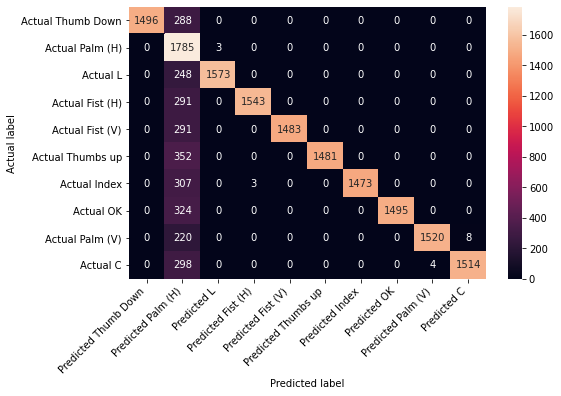

In [31]:
df_cm = conf_matrix
fig = plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=10)

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=10)

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      1784
           1       0.41      1.00      0.58      1788
           2       1.00      0.86      0.93      1821
           3       1.00      0.84      0.91      1834
           4       1.00      0.84      0.91      1774
           5       1.00      0.81      0.89      1833
           6       1.00      0.83      0.90      1783
           7       1.00      0.82      0.90      1819
           8       1.00      0.87      0.93      1748
           9       0.99      0.83      0.91      1816

    accuracy                           0.85     18000
   macro avg       0.94      0.85      0.88     18000
weighted avg       0.94      0.85      0.88     18000



The model is satisfying with an average accuracy of 85%.